<a href="https://colab.research.google.com/github/liquidx/ml/blob/main/Mobile_GANs_v2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile Screen GAN



## Introduction



This is a work in progress notebook where I'm exploring how to build a GAN. 

## Background

At the moment, I'm a beginner with ML. I have only successfully trained a few models, and mostly relying on tutorials to learn and understand how to do it. 

I'll be explaining some of the choices and alternatives through out the notebook.


## GAN Inputs & Outputs

This GAN is to generate plausible mobile screenshots based on a dataset of Android screenshots from the [Rico Dataset](http://interactionmining.org/rico). Thie dataset is loaded from [Hugging Face datasets - ncoop57/rico_captions](https://huggingface.co/datasets/ncoop57/rico_captions). 

By changing the datasets this GAN should be generalizable to be trained by other data sets.

## Based on

This notebook is an amalgamation of three different DCGAN tutorials which I've liberally borrowed and learned from.

 * [Nicholas Renotte : Build a Generative Adversarial Neural Network with Tensorflow and Python](https://youtu.be/AALBGpLbj6Q)
   
   The initial version was based entirely on the video, except that I made modifications to extend the example to use a dataset from Hugging Face Datasets as well as adding an extra dimension to generate color images rather than greyscale.

 * [Machine Learning Mastery: How to developer a GAN for a CIFAR 10 Small Object Photographs from scratch](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)
   
   This tutorial takes a quite different approach to the above tutorial. I ended moving to this more modern model structure and training loop from this rather than the back propogation (via GradientTape). The GradientTape manual back propogation seemed to be harder to get right for me.

 * [TensorFlow Deep Convolutional GAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

   This tutorial is quite clear, but very similar to the Machine Learning Mastery one. The difference is the training step is using `@tf.function`, which I still don't quite understand and using the back-propagation using `GradientTape` to manually apply the gradients from the losses back into the optimizer. I need to investigate that technique more. This tutorial was quite helpful to introduce checkpointing using `tf.training.Checkpoint` which is crucial because of how long GANs need to train for.


## Logging

This notebook also is using Weights and Biases (wandb) and Neptune for training logging. This is an experiment to get familiar with those MLOps tools.


## 1 Dependencies

In [ ]:
!pip -q install datasets transformers pillow rich neptune-client wandb

In [63]:
import os
import numpy as np
import PIL
import PIL.Image
import pathlib
import pickle 
import time

from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from datasets import load_dataset
from datasets import Image
from rich import inspect
from transformers import DataCollatorWithPadding


In [64]:
# Dependencies for Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model

# For subclassing
from tensorflow.keras.models import Model
# For ModelMonitor Callback
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


Google Colab specific initialization. This noteboook stores all checkpoints and results in Google Drive to avoid issues when the runtime is disconnected.

In [65]:
HAS_COLAB = False
try:
  import google.colab
  HAS_COLAB = True
except ImportError:
  pass


In [66]:
CHECKPOINTS_DIR = './checkpoints'
if HAS_COLAB:
  google.colab.drive.mount('/content/drive')
  CHECKPOINTS_DIR = '/content/drive/MyDrive/ML/checkpoints/mobilegan'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Remote monitoring with neptune


In [76]:
NEPTUNE_CREDENTIALS_PATH = os.path.join(CHECKPOINTS_DIR, "neptune.txt")
NEPTUNE_CREDENTIALS = None
if os.path.exists(NEPTUNE_CREDENTIALS_PATH):
  try:
    import neptune.new as neptune
    with open(NEPTUNE_CREDENTIALS_PATH, 'r') as f:
      NEPTUNE_CREDENTIALS = f.read().strip()
  except ImportError:
    pass # silent fail


In [92]:
WANDB_CREDENTIALS_PATH = os.path.join(CHECKPOINTS_DIR, "wandb.txt")
WANDB_CREDENTIALS = None

if os.path.exists(WANDB_CREDENTIALS_PATH):
  import wandb
  wandb.login()
  

ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/gpu_memory. Invalid point: 2022-08-13T04:50:46.113Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/memory. Invalid point: 2022-08-13T04:50:46.113Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/cpu. Invalid point: 2022-08-13T04:50:46.113Z


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2 Initialize

### Confirm GPUs

Confirm that there are some GPUs and the settings are set correctly so they don't run out of memory.

In [68]:
# Bringing in tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Global training parameters

In [69]:
DEFAULT_RNG_SEED = 123  # Unused?

IMAGE_SIZE = (64, 32)

BATCH_SIZE = 128
BUFFER_SIZE = 50000 # Unused if loading from images_from_dir
PREFETCH_SIZE = 64 # Unused if loading frim images_from_dir

LATENT_DIM = 128


## 3 Load Dataset

### Load the dataset from Hugging Face Datasets. 

`rico_dataset` is only used to get the path to the `screenshot_dir` using the `screenshot_path` of the first row

The files are stored in `/root/.huggingface/...` 


In [31]:
rico_dataset = load_dataset("ncoop57/rico_captions", split="train")


### Load Images & Normalize



In [32]:
def scale_image_unit(img):
  """Convert numpy image data from [-1,1] to [0,1] range."""
  return img / 2 + 0.5

def scale_images_to_minus_plus_one(image):
  """Normalize RGB values to -1 to -1"""
  return (image - 127.5) / 127.5

def load_using_keras_dataset(dirname):
  """
  This will already do batching/shuffling/prefetch
  https://github.com/keras-team/keras/blob/v2.9.0/keras/utils/image_dataset.py#L29-L235
  """
  ds = image_dataset_from_directory(dirname, 
                                    labels=None,
                                    color_mode="rgb",
                                    shuffle=True,
                                    image_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE)
  return ds.map(scale_images_to_minus_plus_one)
  

### (Unused) Alternative way to load the data.

`rico_dataset` have data rows containing a column called `screenshot_path`. I thought that I could use `rico_dataset.map()` to give it a function to load the images and have it execute lazily (when the row needed to be read). But it instead tried to load all images into memory on call, so I left it alone and used another way to load the image data.

In [33]:
def _unused__images_dataset(rico_dataset):
  # Convert to TensorFlow compat data set
  rico_dataset_tf = rico_dataset.to_tf_dataset(columns=['screenshot_path'], batch_size=BATCH_SIZE, shuffle=True)

  # Load images and normalize using HF Datasets
  # This is hugely inefficient since it tries to load them all rather than only
  # when we use them.
  def hfd_load_image_and_normalize(row):
    img = tf.keras.utils.load_img(row['screenshot_path'], 
                                  grayscale=False, 
                                  color_mode='rgb', 
                                  target_size=IMAGE_SIZE)
    data = tf.keras.preprocessing.image.img_to_array(img)
    row['image'] = data / 255.0
    return row

  return rico_dataset.map(hfd_load_image_and_normalize)


def __unused_load_image_and_normalize(path):
  """Method used to load images and normalize to have values between 0-1.0."""
  print(path.eval())
  img = tf.keras.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=IMAGE_SIZE)
  data = tf.keras.preprocessing.image.img_to_array(img)
  return scale_images_to_minus_plus_one(data)


### Create the image-only dataset: `ds`

In [34]:
screenshot_dir = os.path.dirname(rico_dataset[0]["screenshot_path"])
ds = load_using_keras_dataset(screenshot_dir)

Found 24598 files belonging to 1 classes.


Since ds was loaded using load_using_keras_dataset, calling `ds.take(1)` will return the first batch. The ElementSpec will be:

```
TensorSpec(shape=(None, 64, 32, 3), dtype=tf.float32, name=None)
```

The first dimension is None because what is returned is a batch. The batch can have undefined number of rows (if there are any remainders when divided by the batch size). This is normal.

The second and third dimensions is the rows and cols of the image and then fourth dimension is the RGB color values (3).


In [35]:
# Verify the spec for the first batch.
ds.take(1).element_spec

TensorSpec(shape=(None, 64, 32, 3), dtype=tf.float32, name=None)

## 4 Inspect Dataset (optional)

A quick way to visualize the data set that is in `ds`. Takes a batch, convert it to `numpy` and plots it into a matplotlib `subplots()`.

(128, 64, 32, 3)


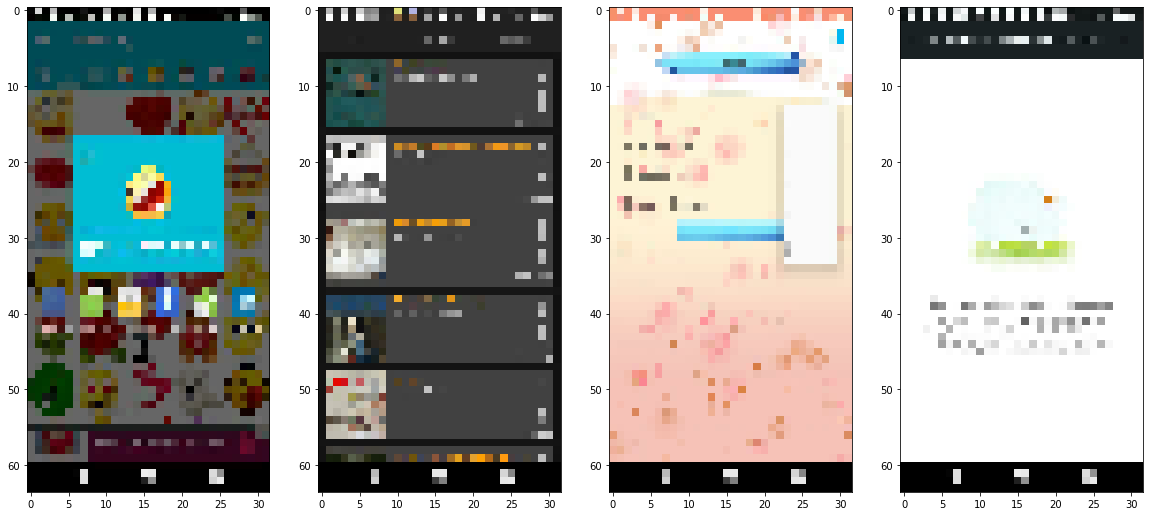

In [ ]:
data_iterator = ds.as_numpy_iterator()
plot_count = 4
fig, ax = plt.subplots(ncols=plot_count, figsize=(20, 10))
# gets a batch (which will be batch size)
batch = data_iterator.next()
print(batch.shape)

for i in range(plot_count):
  ax[i].imshow(np.squeeze(scale_image_unit(batch[i])))


Another way to visualize the plots by using matplotlib `figure()` and `subplot()`

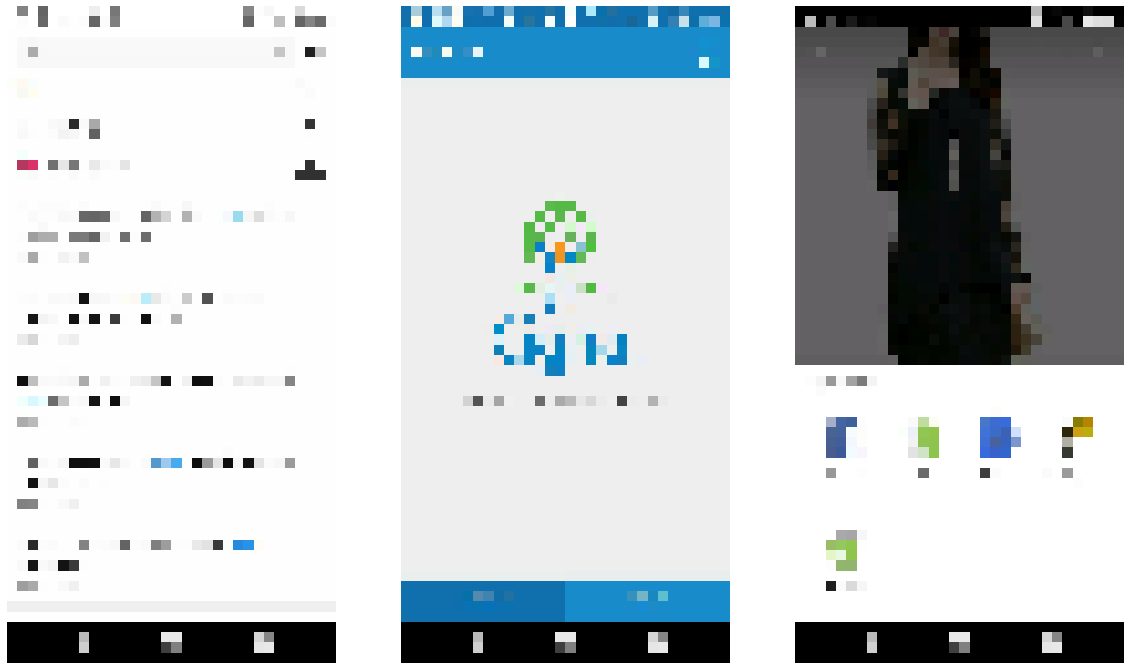

In [ ]:
# Visualize what we've loaded
plt.figure(figsize=(20, 60))
for images in ds.take(1):  
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].numpy().astype("uint8"))
    plt.imshow(scale_image_unit(images[i].numpy()))
    plt.axis("off")

## 5 GAN Model

This section the GAN model is built, including the generator and discriminator along with some functions to help use the generator by providing it with the correct latent seeds.

### Image Generation

Methods to generate the generated images given the generator model.

In [36]:
def generate_latent_points(latent_dim, n_samples):
	"""Generate random points that will feed the generator."""
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(generator_model, latent_dim, img_count):
  """Generate some fake sample image data for the discriminator."""
  seed = generate_latent_points(latent_dim, img_count)
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  imgs = generator_model(seed, training=False)
  return imgs	

Methods for showing generated images from the generator model.

Both methods are available, but for exporting, `generate_and_show()` is cleaner and more scalable.

In [73]:
def generate_and_show_subplots(g_model, latent_dim, img_count=4):
  """Show generated imges using plt.subplots()."""
  imgs = generate_fake_samples(g_model, latent_dim, img_count)
  fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  for i, img in enumerate(imgs):
    ax[i].imshow(np.squeeze(scale_image_unit(img)))

def generate_and_show(g_model, latent_dim, epoch=0, rows=2, cols=4, scale=4, 
                      seed=None, output_dir=None):
  """
  Show generated images using plt.figure() & plt.subplot(). 
  Optionally allow saving the results to disk.
  """
  img_count = rows * cols
  if seed is None:
    seed = generate_latent_points(latent_dim, img_count)
  imgs = g_model(seed, training=False)
  fig = plt.figure(figsize=(cols * scale, rows * scale * 2))

  for i in range(imgs.shape[0]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(scale_image_unit(imgs[i])))
    plt.axis('off')

  if output_dir:
    path = os.path.join(output_dir, 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.savefig(path)
    
  plt.show()

  return fig


### Checkpointing

`checkpoint_models()` defines what weights and optimizer config is saved. Checkpoint will pack everything into a single file which makes it convenient to manage. All paramaters passed, when restored will be directly applied to the passed models.

In [38]:
def checkpoint_models(g_model, d_model, g_opt, d_opt):
  return tf.train.Checkpoint(g_model=g_model,
                             d_model=d_model,
                             g_opt=g_opt,
                             d_opt=d_opt,)


To keep track of the epoch and losses, we save this separatly from `tf.train.Checkpoint`. Oddly `Checkpoint` doesn't have any capability to save the training history, so we have to do it manually here.

In [39]:
def save_training_history(history, history_path):
  with open(history_path, 'wb') as f:
    pickle.dump(history, f)
  return history

def load_training_history(history_path):
  if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
      return pickle.load(f)
  else:
    return []


### Model Definition

Model is primarily based on  [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/) and [DCGAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) along with some tips from Machine Learning Mastery on optimizing GANs.


Adding from build_generator_v2:
* batchnorm to stablize
* Changing activation to tanh
* Fix the kernel to be square

In [40]:
def build_generator_v2_2(latent_dim):
  """
  This generator is built to go from a `latent_dim` 
  random seed, to a 4x8, 8x16, 16x32 image.

  Note that the defintion array is set up as row, col.
  TODO: This might be a mistake??
  """
  model = Sequential()

  n = 256 
  rows = 8
  cols = 4
  n_nodes = n * rows * cols

  # First hidden layer has enough nodes to represent a low
  # rest version of the output image.
  model.add(Dense(n_nodes, input_dim=latent_dim))

  # It is said that Batch normalization to help stablize the GAN. Ref:
  # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
  #
  # For this particular model, we are not using BatchNormalization. When
  # trying this here, it ends up stuck generating noisy and not converging.
  # model.add(BatchNormalization(momentum=0.0))

  # LeakyReLU is recommended over ReLU, with a alpha of 0.2
  # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((rows, cols, n)))

  # Upsample from 4x8 to 8x16
  # You can use UpSampling2D + Conv2D, or use Conv2DTranspose.
  # https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
  model.add(Conv2DTranspose(n, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 8x16 to 16x32
  model.add(Conv2DTranspose(n, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 16x32 to 32x64
  model.add(Conv2DTranspose(n, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Output layer
  # Using tanh as the activation is the best for GANs
  # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
  #
  # Note: tanh is returning values in the range [-1, 1]
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model


In [41]:
def build_discriminator_v2_2(in_shape=(64, 32, 3)):
  """Returns the discriminator for the GAN.

  Note: We do not compile the discriminator as in the tutorial this came from so
  that we construct the GAN model so there is a symmetry with build_generator().

  https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

  """
  model = Sequential()

  # Normal
  # Not really sure why it's using a 3x3 kernel.
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  # Downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Classifier
  model.add(Flatten())
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid'))
  return model

In [42]:
def create_gan_model_v2_2(latent_dim, 
                          g_opt_learning_rate=0.0001, 
                          d_opt_learning_rate=0.0001):
  """Create the GAN model.
  
  @return: (gan_model, generator, dicriminator, g_opt, d_opt)
  """
  # Generator itself has no optimizers (not sure why.)
  generator = build_generator_v2_2(latent_dim)

  # Discriminator has it's own optimizer and loss, this is compiled with
  # the metrics monitored as 'accuracy'.
  discriminator = build_discriminator_v2_2()
  d_opt = Adam(learning_rate=d_opt_learning_rate,  beta_1=0.5)
  d_loss = BinaryCrossentropy()
  discriminator.compile(loss=d_loss, optimizer=d_opt, metrics=['accuracy'])

  # Setting discriminator as not trainable is important so that
  # when optimizing the GAN it doesn't change the discriminator 
  # weights. We manually train it when feeding in real/fake images.
  discriminator.trainable = False

  # Create the GAN by combining both generator and the discriminator
  # into this sequential model. 
  # 
  # This is a very smart way to set up the GAN so we don't need to
  # manually do the back-propogation.
  gan_model = Sequential()
  gan_model.add(generator)
  gan_model.add(discriminator)
  g_opt = Adam(learning_rate=g_opt_learning_rate,  beta_1=0.5)
  g_loss = BinaryCrossentropy()
  gan_model.compile(loss=g_loss, optimizer=g_opt)

  return (gan_model, generator, discriminator, g_opt, d_opt)  

## 8. Train

The actual training steps. Up to now, the model has not be created. This section creates the model and starts the training.

Note, throughout the training of this GAN, we are using the outputs as:

 - Real Images : y_hat = 0
 - Fake Images : y_hat = 1


Alterantive training:

In Nicholas Renotte's tutorial, a subclassed  `keras.Model` was used to hold on to the discriminator (`d_model`) and generator (`g_model`) and it used `train_step()` to override the behavior and manually do the back-propagation. TensorFlow's tutorial also used this same back-propagation method but avoided using the subclass of the `keras.Model`.

I found that the way Machine Learning Mastery's method of using a `Sequential()` model that contained the generator and discriminator more straightforward than the subclassing, so I stuck with that. It also meant I didn't have to do the GradientTape() and manually do the loss calculation, applyGradients, etc which made it more simple.


In [96]:
def train_gan_v2(gan_model, g_model, d_model, g_opt, d_opt,
                 dataset, latent_dim, 
                 epochs=200, 
                 initial_epoch=0, 
                 preserve_lr=False,
                 checkpoint_dir=None,
                 checkpoint_interval=10,
                 history_path=None,
                 samples_dir=None,
                 samples_seed_path=None,
                 neptune_run=None,
                 wandb_run=None):
  """
  Training loop for the GAN.
  """

  # Live preview updated after each epoch.
  preview_cols = 4
  preview_rows = 2
  samples_seed = generate_latent_points(latent_dim, preview_cols * preview_rows)

  history = []
  checkpoint = None
  checkpoint_prefix = None
  checkpoint_manager = None
  epoch_var = tf.Variable(initial_epoch + 1, dtype='uint32')


  # Initialize checkpointing and load the model if it exists.
  if checkpoint_dir:
    g_opt_lr = g_opt.learning_rate.value()
    d_opt_lr = d_opt.learning_rate.value()
    checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
    #checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, 
                                                    directory=checkpoint_dir, 
                                                    max_to_keep=None,
                                                    step_counter=epoch_var,
                                                    checkpoint_interval=checkpoint_interval)
    checkpoint_manager.restore_or_initialize()
    if preserve_lr:
      g_opt.learning_rate.assign(g_opt_lr)
      d_opt.learning_rate.assign(d_opt_lr)
      print(f'Model learning rates g_opt= {g_opt_lr}')
      print(f'Model learning rates d_opt= {d_opt_lr}')

  # Initialize training history logging that is also needed for
  # resuming training.
  if history_path:
    history = load_training_history(history_path)
    if len(history):
      latest_epoch = -1
      for hist in history:
        latest_epoch = max(hist['epoch'], latest_epoch)
      initial_epoch = latest_epoch + 1 # start from the next epoch

  # Save and store the samples seed during training.
  if samples_seed_path:
    if os.path.exists(samples_seed_path):
      with open(samples_seed_path, 'rb') as f:
        samples_seed = pickle.load(f)
    else:
      with open(samples_seed_path, 'wb') as f:
        pickle.dump(samples_seed, f)

  print(f'Starting training from epoch {initial_epoch} until {epochs}')

  if neptune_run:
    neptune_run['parameters/seed'] = samples_seed

  for epoch in range(initial_epoch, epochs):
    start = time.time()
    epoch_var.assign(epoch + 1)
    g_loss_sum = 0
    d_loss_fake_sum = 0
    d_loss_real_sum = 0
    batch_count = 0

    for batch in dataset.as_numpy_iterator():
      if batch.shape[0] < BATCH_SIZE:
        continue # skip if it is not a full batch.

      # Create both the real image set (from batch) and the fake
      # image set that is from the generator.
      batch_count += 1
      batch_size = BATCH_SIZE
      real_images = batch
      fake_images = generate_fake_samples(g_model, latent_dim, batch_size)
      X_real, y_real = (batch, np.zeros(batch_size))
      X_fake, y_fake = (fake_images, np.ones(batch_size))

      # Add noise to the outputs.
      # Add a bit of confusion in to the discriminator to avoid it being
      # too good.
      # 
      # 0.15 is from Nicholas Renotte video. 
      noise_real = 0.15 * tf.random.uniform(tf.shape(y_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(y_fake))
      y_real += noise_real
      y_fake += noise_fake

      # Train the discriminator on both real and fake.
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

      # Train the GAN (generator-only) to try to fool the discriminator
      # That means it is a win if the generator gets a real verdict (0)
      # for their inputs.
      X_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.zeros((batch_size, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      d_loss = d_loss_real + d_loss_fake

      g_loss_sum += g_loss
      d_loss_real_sum += d_loss_real
      d_loss_fake_sum += d_loss_fake
   
    
    # Log and checkpoint
    elapsed = time.time() - start
    g_loss_avg = 0
    d_loss_fake_avg = 0
    d_loss_real_avg = 0
    if batch_count > 0:
      g_loss_avg = g_loss_sum / batch_count
      d_loss_real_avg = d_loss_real_sum / batch_count
      d_loss_fake_avg = d_loss_fake_sum / batch_count

    status = {"epoch": epoch, 
              'd_loss_real': d_loss_real_avg, 
              'd_loss_fake': d_loss_fake_avg,
              'g_loss': g_loss_avg, 
              'elapsed': elapsed }
    if checkpoint:
      history.append(status)
      if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_manager.save()
        save_training_history(history, history_path)

    if neptune_run:
      neptune_run["train/loss/gen"].log(g_loss_avg)
      neptune_run["train/loss/dis_fake"].log(d_loss_fake_avg)
      neptune_run["train/loss/dis_real"].log(d_loss_real_avg)

    if wandb_run:
      wandb_run.log(status)

    # Display progress in the console.
    display.clear_output(wait=True)
    fig = generate_and_show(g_model, latent_dim, epoch=epoch, seed=samples_seed, output_dir=samples_dir)
    if neptune_run:
      neptune_run['train/samples/{:04d}'.format(epoch + 1)].upload(fig)
    for hist in history[-5:]:
      if "elapsed" not in hist:
        hist["elapsed"] = 0        
      print('Epoch: {epoch} d_real={d_loss_real:.3f} d_fake={d_loss_fake:.3f} g_loss={g_loss:.3f} duration={elapsed:.1f}s'.format(**hist))
        
def train_v2_2(epochs=200, 
               run_id=None,
               checkpoint_dir=None, 
               checkpoint_interval=10, 
               history_path=None, 
               samples_dir=None, 
               samples_seed_path=None):
  """Initialize and start the training."""

  # Learning Rates.
  # This is from a bit of trial and error. 
  #
  # Attempts:
  #  - setting it to 0.00002 (d) & 0.002 (g) before but it trained too
  #    slowly/no-progress.
  #  - setting it to 0.0002 (d) & 0.0002 (g) which gave much faster
  #    results, but the generator seemed to experience mode collapse
  #  - setting it (d) to 0.0002 and (g) to 2x of (d) seemed to work well.
  d_opt_lr = 0.0001 # learning rates
  g_opt_lr = d_opt_lr * 4

  # Create the models.
  gan_model, g_model, d_model, g_opt, d_opt = create_gan_model_v2_2(
      LATENT_DIM, 
      g_opt_learning_rate=g_opt_lr, 
      d_opt_learning_rate=d_opt_lr)  
  
  # Initialize Neptune for logging the training run.
  log = None
  if neptune and NEPTUNE_CREDENTIALS:
    neptune_run = neptune.init(
      project="liquidx/mobile-gan",
      api_token = NEPTUNE_CREDENTIALS,
      run = run_id
    )
    neptune_run["parameters"] = {
        "g_learning_rate": g_opt.learning_rate.value(), 
        "d_learning_rate": d_opt.learning_rate.value(),
        "latent_dim": LATENT_DIM
    }
 
  # Initialize Weights and Biases for logging the training run.
  if wandb:
    wandb_run = wandb.init(project="mobile-gan", entity="liquidx")


  # Start the training.
  try:
    train_gan_v2(gan_model, g_model, d_model, g_opt, d_opt,
                ds, LATENT_DIM, 
                preserve_lr=True,
                epochs=epochs,
                checkpoint_dir=checkpoint_dir,
                checkpoint_interval=checkpoint_interval,
                history_path=history_path,
                samples_dir=samples_dir,
                samples_seed_path=samples_seed_path,
                neptune_run=neptune_run,
                wandb_run=wandb_run)
  except KeyboardInterrupt:
    if neptune_run:
      neptune_run.stop()
    if wandb_run:
      wandb_run.finish()


ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/memory. Invalid point: 2022-08-13T05:02:36.235Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/gpu_memory. Invalid point: 2022-08-13T05:02:36.235Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/cpu. Invalid point: 2022-08-13T05:02:36.235Z


In [94]:
model_version = '2.6'
neptune_run_id = 'MOBGAN-3'


current_checkpoints_dir = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}')
current_samples_dir = os.path.join(CHECKPOINTS_DIR, f'samples-v{model_version}')

current_history_path = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}-history.pkl')
current_samples_seed_path = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}-samples-seed.pkl')

if HAS_COLAB:
  os.makedirs(current_checkpoints_dir, exist_ok=True)
  os.makedirs(current_samples_dir, exist_ok=True)


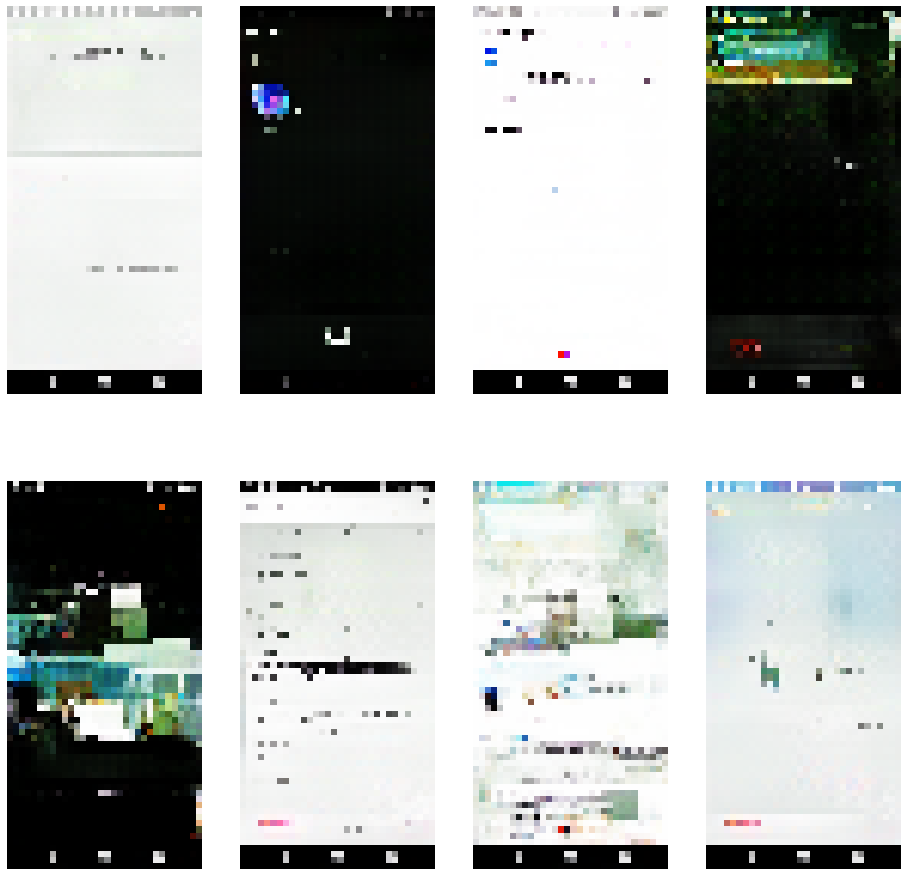

Epoch: 565 d_real=0.300 d_fake=0.287 g_loss=2.627 duration=141.9s
Epoch: 566 d_real=0.303 d_fake=0.288 g_loss=2.633 duration=141.9s
Epoch: 567 d_real=0.302 d_fake=0.289 g_loss=2.624 duration=141.9s
Epoch: 568 d_real=0.300 d_fake=0.288 g_loss=2.640 duration=104.1s
Epoch: 569 d_real=0.303 d_fake=0.289 g_loss=2.627 duration=104.0s


ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:06:41.175Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:06:41.177Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:06:41.178Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:06:41.179Z
ERROR:neptune.new.in

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/liquidx/mobile-gan/e/MOBGAN-3


ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:09:03.103Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:09:03.103Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:09:03.245Z
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stdout. Invalid point: 2022-08-13T09:09:03.251Z
ERROR:neptune.new.in

d_loss_fake,▃▇▅█▅▅▅▄▅▅█▃▆▄▄▇▂▁▂▂▅▅▃▇▄█▆▇▃▄▁▂▆▃▆▅▄▅▃▆
d_loss_real,▆▇▆██▅▅▅▆▇▆▁▆▆▆▆▆▁▄▅▄▄▇█▃▆▇▅▅▅▃▂▆▄▇▄▆▅▃▆
elapsed,▂█▁▁██▁█▁▁▁██▁██▁▁▁▁▁█▁█▁▁▁██▁█▁▁▁▁█▁██▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
g_loss,▂▄▃▃▇▄▅▁▄▄▄▄▅▃▃▆▅▇█▄▅▆▄▆▅▅▇▅▄▃▅█▅▆▄▆▄█▆▇
d_loss_fake,0.28938
d_loss_real,0.30288
elapsed,103.99308
epoch,569
g_loss,2.62747


In [97]:
train_v2_2(epochs=1000,
           run_id=neptune_run_id,
           checkpoint_dir=current_checkpoints_dir, 
           checkpoint_interval=5, 
           history_path=current_history_path,
           samples_dir=current_samples_dir,
           samples_seed_path=current_samples_seed_path)


In [ ]:
# Test the generated model's initial output to check if it is properly generating
def examine_g_model():
  test_g_model = build_generator_v2_2(LATENT_DIM)
  generate_fake_samples(test_g_model, LATENT_DIM, 1)
  generate_and_show(test_g_model, LATENT_DIM)


## Inspection

Performance inspection

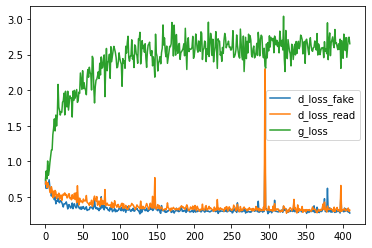

In [60]:
def plot_losses_v2(hist):
  plt.plot([h['d_loss_fake'] for h in hist], label='d_loss_fake')
  plt.plot([h['d_loss_real'] for h in hist], label='d_loss_read')
  plt.plot([h['g_loss'] for h in hist], label='g_loss')
  plt.legend()
  plt.show()

plot_losses_v2(load_training_history(current_history_path))

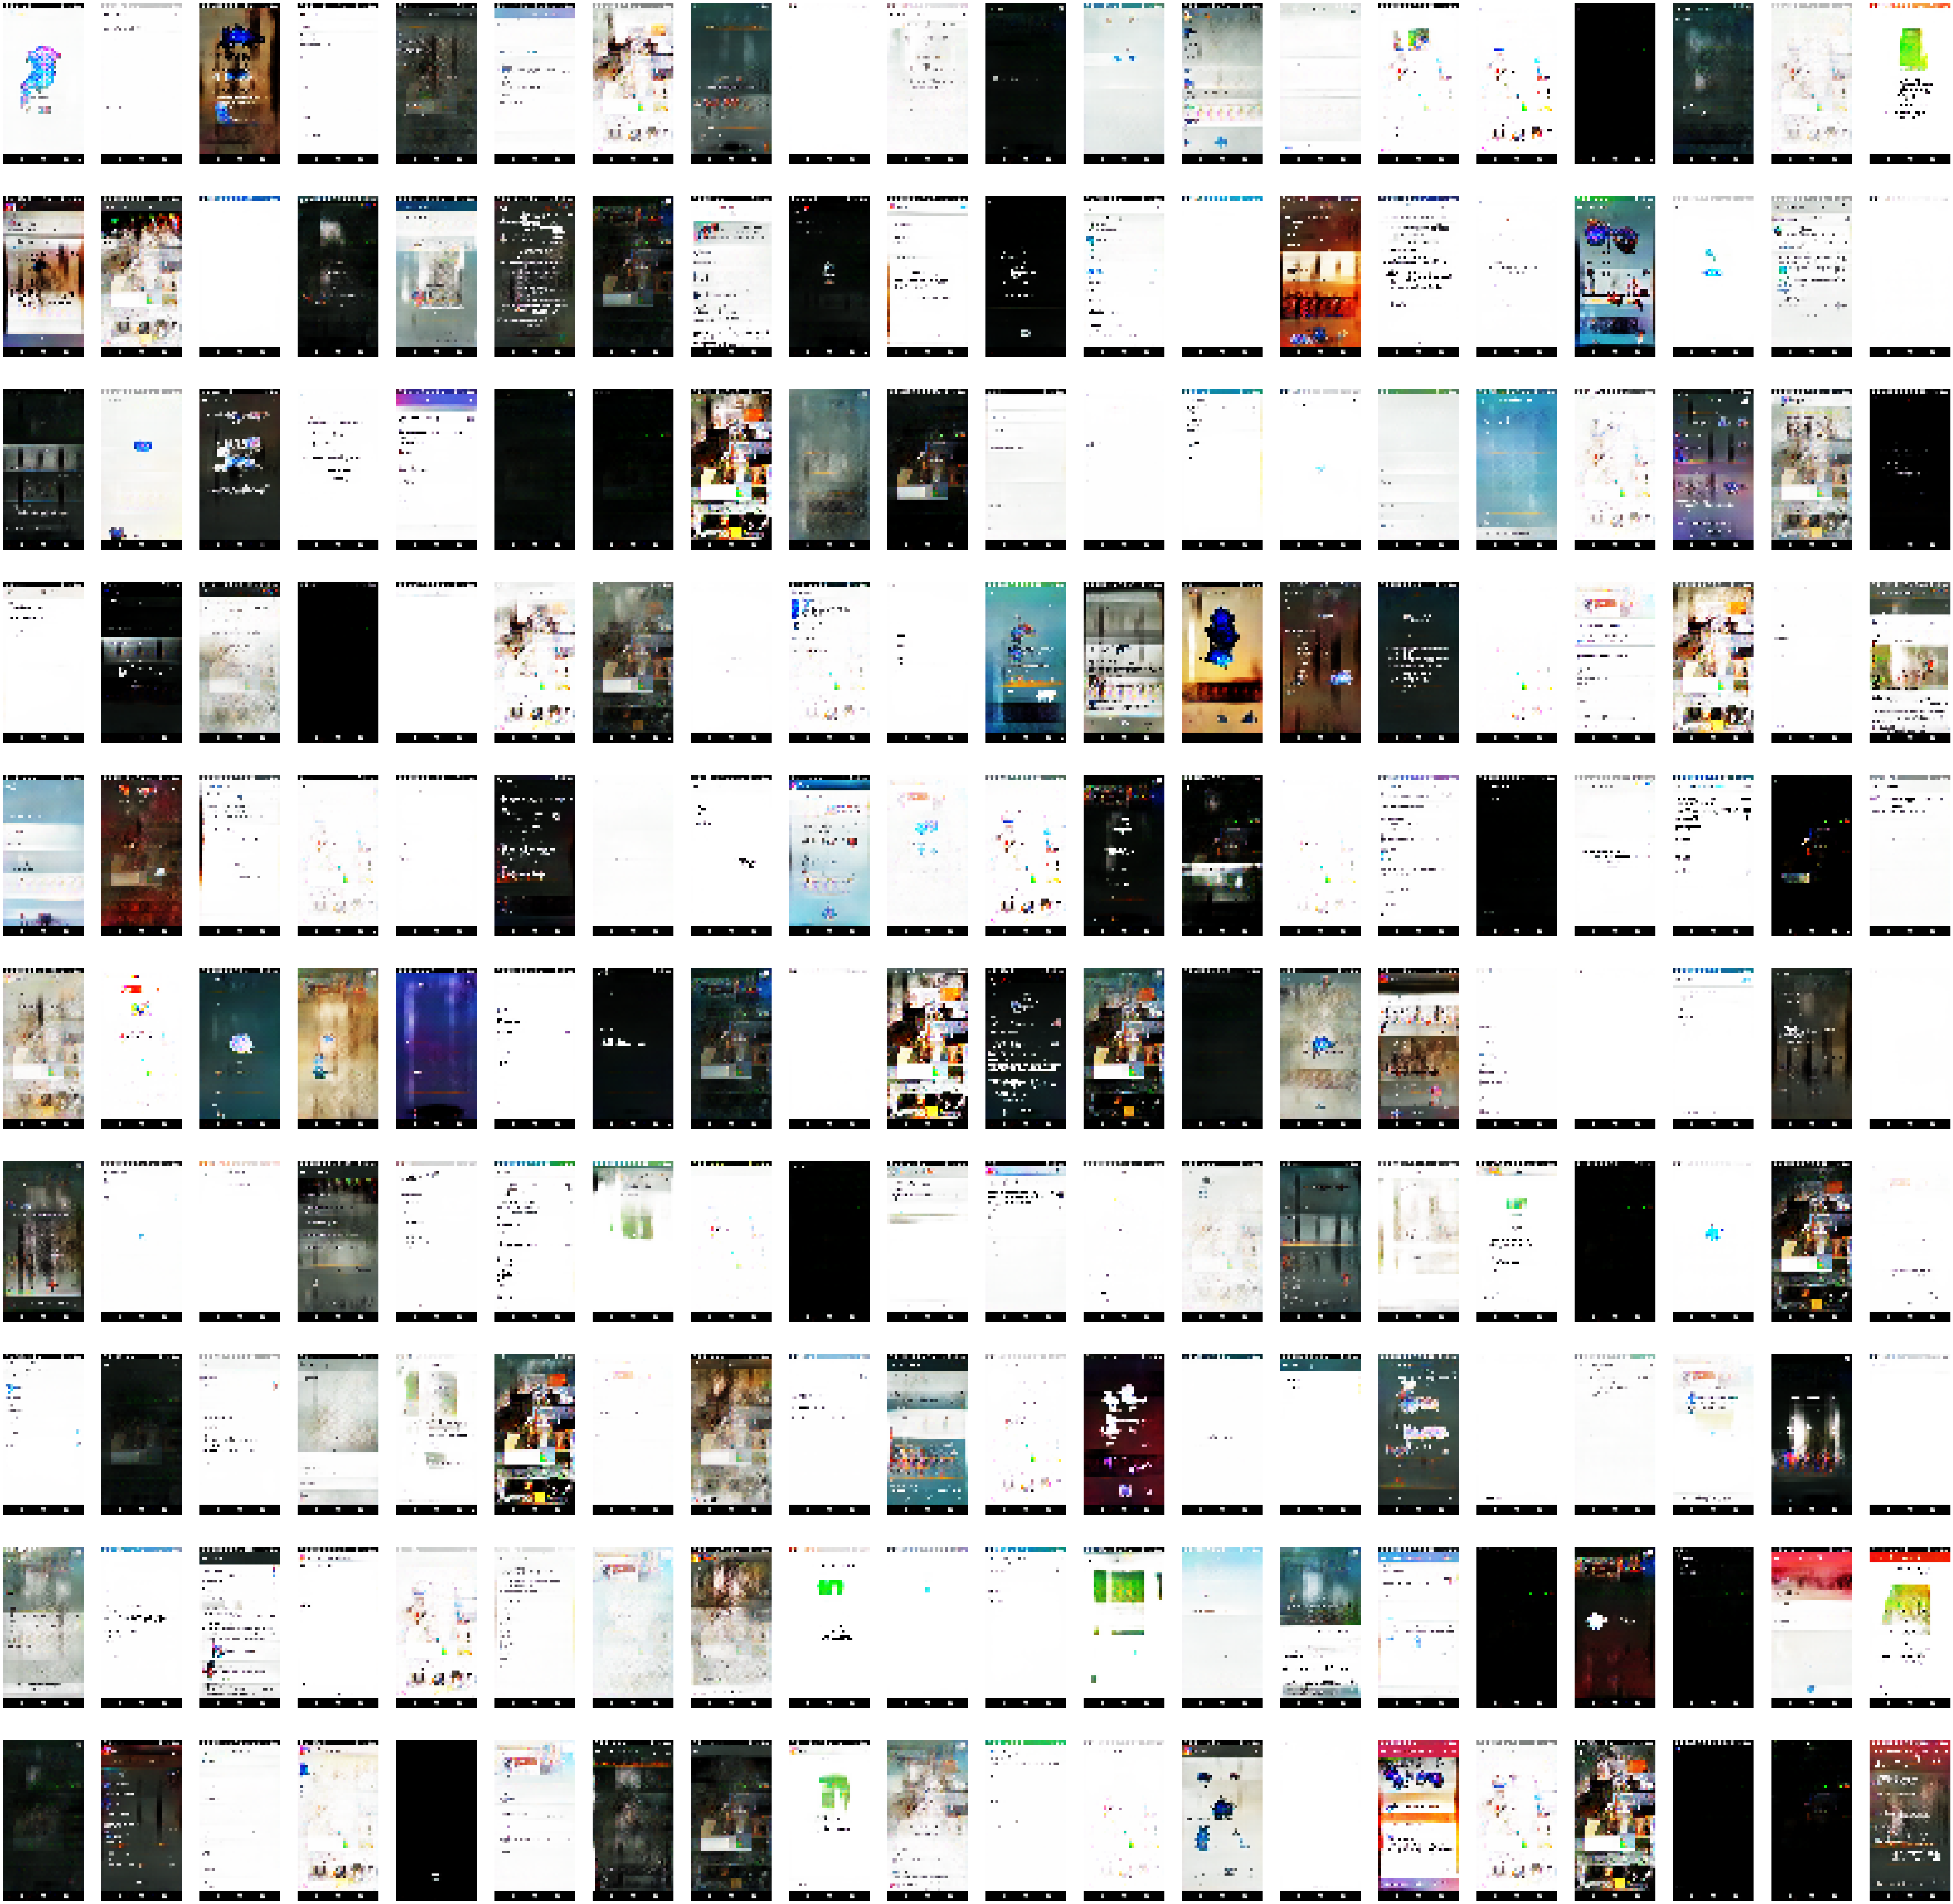

/content/drive/MyDrive/ML/checkpoints/mobilegan/model-v2.6


In [61]:
def test_model(checkpoint_dir):
  gan_model, g_model, d_model, g_opt, d_opt = create_gan_model_v2_2(LATENT_DIM)

  checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
  checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=current_checkpoints_dir, max_to_keep=None)
  checkpoint_manager.restore_or_initialize()  

  generate_and_show(g_model, LATENT_DIM, rows=10, cols=20, scale=4)

  # img_count = 4
  # imgs = generate_fake_samples(g_model, LATENT_DIM, img_count)
  # fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  # for i, img in enumerate(imgs):
  #   ax[i].imshow(np.squeeze(img))

test_model(current_checkpoints_dir)    
print(current_checkpoints_dir)